# CS 20 : TensorFlow for Deep Learning Research
## Lecture 05 : Variable sharing and managing experiments
### Applied example with tf.data
same contents, but different style with [Lec05_Applied example with tf.data.ipynb](https://nbviewer.jupyter.org/github/aisolab/CS20/blob/master/Lec05_Variable%20sharing%20and%20managing%20experiments/Lec05_Applied%20example%20with%20tf.data.ipynb)

- Using **high-level api** `tf.keras.layers` and `eager execution`
- Creating the **input pipeline** with `tf.data`
- Creating the model as **subclassing** `tf.keras.Model`
- Training the model with **learning rate scheduling** by exponential decay learning rate
- Saving the model and Restoring the model

### Setup

In [1]:
from __future__ import absolute_import, division, print_function
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

print(tf.__version__)
tf.enable_eager_execution()

1.12.0


### Load and Pre-process data

In [2]:
(x_train, y_train), (x_tst, y_tst) = keras.datasets.mnist.load_data()
x_train = x_train  / 255
x_train = x_train.reshape(-1, 784).astype(np.float32)
x_tst = x_tst / 255
x_tst = x_tst.reshape(-1, 784).astype(np.float32)
y_train = y_train.astype(np.int32)
y_tst = y_tst.astype(np.int32)

In [3]:
tr_indices = np.random.choice(range(x_train.shape[0]), size = 55000, replace = False)

x_tr = x_train[tr_indices]
y_tr = y_train[tr_indices]

x_val = np.delete(arr = x_train, obj = tr_indices, axis = 0)
y_val = np.delete(arr = y_train, obj = tr_indices, axis = 0)

print(x_tr.shape, y_tr.shape)
print(x_val.shape, y_val.shape)

(55000, 784) (55000,)
(5000, 784) (5000,)


### Define DNN Classifier with two hidden layer

In [4]:
class DNNClassifier(keras.Model):
    def __init__(self, num_classes, hidden_dims = [100, 50]):
        super(DNNClassifier, self).__init__()
        self.__layers = []

        for h_dim in hidden_dims:
            self.__layers.append(keras.layers.Dense(units=h_dim, kernel_initializer='glorot_normal',
                                                    activation=keras.activations.tanh))
        else:
            self.__layers.append(keras.layers.Dense(units=num_classes, kernel_initializer='glorot_normal'))
    
    def call(self, inputs):
        for layers in self.__layers:
            outputs = layers(inputs)
        return outputs

### Create a model of DNN Classifier

In [5]:
dnn = DNNClassifier(num_classes=10)

### Train a model
Applying exponential decay learning rate to train DNN model  
```python
decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)

```

* `tf.train.exponential_decay` : https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay
* Object-based saving : https://www.tensorflow.org/guide/eager#object-based_saving
* Summaries and TensorBoard : https://www.tensorflow.org/guide/eager#object-oriented_metrics

In [6]:
# define loss function
def loss_fn(model, x, y):
    logits = model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)

In [7]:
# hyper-parameter
epochs = 15
batch_size = 100
learning_rate = .005
total_step = int(x_tr.shape[0] / batch_size)
# print(total_step)

In [8]:
## create input pipeline with tf.data
# for train
tr_dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
tr_dataset = tr_dataset.shuffle(buffer_size=10000)
tr_dataset = tr_dataset.batch(batch_size=batch_size)
print(tr_dataset)

# for validation
val_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_dataset = val_dataset.batch(batch_size=batch_size)
print(val_dataset)

<BatchDataset shapes: ((?, 784), (?,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((?, 784), (?,)), types: (tf.float32, tf.int32)>


In [9]:
# applying exponential decay learning rate to train dnn model
global_step = tf.train.get_or_create_global_step()

exp_decayed_lr = tf.train.exponential_decay(learning_rate=learning_rate,
                                            global_step=global_step,
                                            decay_steps=total_step * 5,
                                            decay_rate=.9,
                                            staircase=True)
# creating optimizer
opt = tf.train.AdamOptimizer(learning_rate=exp_decayed_lr)

# creating check point (Object-based saving)
checkpoint_dir = '../graphs/lecture05/applied_example_wkde/'
checkpoint_prefix = os.path.join(checkpoint_dir, 'dnn')
checkpoint = tf.train.Checkpoint(dnn=dnn)

# create writer for tensorboard
summary_writer = tf.contrib.summary.create_file_writer(logdir=checkpoint_dir)

In [10]:
# training
tr_loss_hist = []
val_loss_hist = []

for epoch in range(epochs):

    avg_tr_loss = 0
    avg_val_loss = 0
    tr_step = 0
    val_step = 0
    
    # training
    with summary_writer.as_default(), tf.contrib.summary.always_record_summaries(): # for tensorboard
        for x_mb, y_mb in tr_dataset:
            with tf.GradientTape() as tape:
                tr_loss = loss_fn(dnn, x_mb, y_mb)
            grads = tape.gradient(target=tr_loss, sources=dnn.variables)
            opt.apply_gradients(grads_and_vars=zip(grads, dnn.variables), global_step=global_step)
            tf.contrib.summary.scalar(name='tr_loss', tensor=tr_loss)
            avg_tr_loss += tr_loss
            tr_step += 1
        else:
            avg_tr_loss /= tr_step
            tr_loss_hist.append(avg_tr_loss)
                
        # validation
        for x_mb, y_mb in val_dataset:
            val_loss = loss_fn(dnn, x_mb, y_mb)
            tf.contrib.summary.scalar(name='val_loss', tensor=val_loss)
            avg_val_loss += val_loss
            val_step += 1
        else:
            avg_val_loss /= val_step
            val_loss_hist.append(avg_val_loss)
    
    if (epoch + 1) % 5 == 0:
        print('epoch : {:3}, tr_loss : {:.2f}, val_loss : {:.2f}'.format(epoch + 1, avg_tr_loss, avg_val_loss))
        checkpoint.save(file_prefix=checkpoint_prefix+'-epoch-{}-counter'.format(epoch + 1))

epoch :   5, tr_loss : 0.27, val_loss : 0.28
epoch :  10, tr_loss : 0.25, val_loss : 0.28
epoch :  15, tr_loss : 0.24, val_loss : 0.28


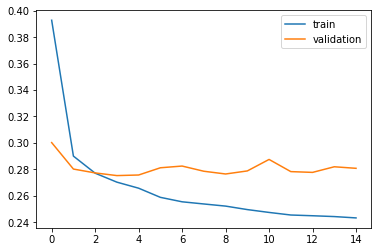

In [11]:
plt.plot(tr_loss_hist, label = 'train')
plt.plot(val_loss_hist, label = 'validation')
plt.legend()

In [12]:
yhat = np.argmax(dnn.predict(x=x_tst), axis=-1)
print('test acc: {:.2%}'.format(np.mean(yhat == y_tst)))

test acc: 92.63%


In [13]:
del dnn

### Restore model

#### Example 1
Restore my model at epoch 15
* reference : https://www.tensorflow.org/guide/eager#object-based_saving

In [14]:
tf.train.get_checkpoint_state(checkpoint_dir='../graphs/lecture05/applied_example_wkde/',)

model_checkpoint_path: "../graphs/lecture05/applied_example_wkde/dnn-epoch-15-counter-3"
all_model_checkpoint_paths: "../graphs/lecture05/applied_example_wkde/dnn-epoch-15-counter-3"

In [15]:
# restore
dnn = DNNClassifier(num_classes=10)

checkpoint = tf.train.Checkpoint(dnn=dnn)
checkpoint.restore(save_path=tf.train.latest_checkpoint('../graphs/lecture05/applied_example_wkde'))
yhat = np.argmax(dnn.predict(x=x_tst), axis=-1)
print('test acc: {:.2%}'.format(np.mean(yhat == y_tst)))

test acc: 92.63%


In [16]:
del dnn

#### Example 2
Restore my model at epoch 10

In [17]:
# restore
dnn = DNNClassifier(num_classes=10)

checkpoint = tf.train.Checkpoint(dnn=dnn)
checkpoint.restore(save_path='../graphs/lecture05/applied_example_wkde/dnn-epoch-10-counter-2')
yhat = np.argmax(dnn.predict(x=x_tst), axis=-1)
print('test acc: {:.2%}'.format(np.mean(yhat == y_tst)))

test acc: 92.27%
